In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from ast import literal_eval
from numpy import nan
import xgboost
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
# from fancyimpute import KNN
# import missingno as msno
from copy import deepcopy
# import impyute.imputation.cs.mice as mice_imputation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score, explained_variance_score, median_absolute_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
import shap
from functools import partial



pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 120)

In [2]:
class XGBQuantile(XGBRegressor):
      def __init__(self,quant_alpha=0.95,quant_delta = 1.0,quant_thres=1.0,quant_var =1.0,base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
                    n_jobs=1, nthread=None, objective='reg:linear', random_state=0,reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,silent=True, subsample=1):
        self.quant_alpha = quant_alpha
        self.quant_delta = quant_delta
        self.quant_thres = quant_thres
        self.quant_var = quant_var

        super().__init__(base_score=base_score, booster=booster, colsample_bylevel=colsample_bylevel,
           colsample_bytree=colsample_bytree, gamma=gamma, learning_rate=learning_rate, max_delta_step=max_delta_step,
           max_depth=max_depth, min_child_weight=min_child_weight, missing=missing, n_estimators=n_estimators,
           n_jobs= n_jobs, nthread=nthread, objective=objective, random_state=random_state,
           reg_alpha=reg_alpha, reg_lambda=reg_lambda, scale_pos_weight=scale_pos_weight, seed=seed,
           silent=silent, subsample=subsample)

        self.test = None

      def fit(self, X, y):
        super().set_params(objective=partial(XGBQuantile.quantile_loss,alpha = self.quant_alpha,delta = self.quant_delta,threshold = self.quant_thres,var = self.quant_var) )
        super().fit(X,y)
        return self

      def predict(self,X):
        return super().predict(X)

      def score(self, X, y):
        y_pred = super().predict(X)
        score = XGBQuantile.quantile_score(y, y_pred, self.quant_alpha)
        score = 1./score
        return score

      @staticmethod
      def quantile_loss(y_true,y_pred,alpha,delta,threshold,var):
        x = y_true - y_pred
        grad = (x<(alpha-1.0)*delta)*(1.0-alpha)-  ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )*x/delta-alpha*(x>alpha*delta)
        hess = ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )/delta 

        grad = (np.abs(x)<threshold )*grad - (np.abs(x)>=threshold )*(2*np.random.randint(2, size=len(y_true)) -1.0)*var
        hess = (np.abs(x)<threshold )*hess + (np.abs(x)>=threshold )
        return grad, hess

      @staticmethod
      def original_quantile_loss(y_true,y_pred,alpha,delta):
        x = y_true - y_pred
        grad = (x<(alpha-1.0)*delta)*(1.0-alpha)-((x>=(alpha-1.0)*delta)& (x<alpha*delta) )*x/delta-alpha*(x>alpha*delta)
        hess = ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )/delta 
        return grad,hess


      @staticmethod
      def quantile_score(y_true, y_pred, alpha):
        score = XGBQuantile.quantile_cost(x=y_true-y_pred,alpha=alpha)
        score = np.sum(score)
        return score

      @staticmethod
      def quantile_cost(x, alpha):
        return (alpha-1.0)*x*(x<0)+alpha*x*(x>=0)

      @staticmethod
      def get_split_gain(gradient,hessian,l=1):
        split_gain = list()
        for i in range(gradient.shape[0]):
          split_gain.append(np.sum(gradient[:i])/(np.sum(hessian[:i])+l)+np.sum(gradient[i:])/(np.sum(hessian[i:])+l)-np.sum(gradient)/(np.sum(hessian)+l) )

        return np.array(split_gain)

In [3]:
def mape(y_actual, y_pred):
    y_actual = y_actual[target].tolist()
    y_pred = [i if type(i) == list else i for i in y_pred.tolist()]
    return (np.sum([np.abs((i-j)/i) for i,j in zip(y_actual, y_pred)])*100)/len(y_actual)

def regression_report(y_true, y_pred):
    ev = explained_variance_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    try:
        msle = mean_squared_log_error(y_true, y_pred)
    except:
        msle = "error"
    medal = median_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    try:
        mape_score = mape(y_true, y_pred)
    except Exception as e:
        print(e)
        mape_score = None
    response = {
        "Explained Variance": ev,
        "Mean Squared Error": mse,
        "Mean Absolute Error": mae,
        "Mean Squared Log Error": msle,
        "Median Absolute Error": medal,
        "MAPE": mape_score,
        "r2_score": r2,
        "RMSE": mse**0.5
    }
    return response

In [4]:
df = pd.read_csv("network_analysis_final_file.csv")
county_df = pd.read_csv("us_county.csv")
target = 'cases'

In [5]:
df.head(2)

,date,county,PM2,PM10,O3,PM2_cdtw_betweenness,PM2_cdtw_closeness,PM2_cdtw_clustering,PM2_cdtw_communicability_betweeness,PM2_cdtw_current_flow_betweenness,PM2_cdtw_current_flow_closeness,PM2_cdtw_degree,PM2_cdtw_harmonic,PM2_cdtw_load,PM2_correlation_betweenness,PM2_correlation_closeness,PM2_correlation_clustering,PM2_correlation_communicability_betweeness,PM2_correlation_current_flow_betweenness,PM2_correlation_current_flow_closeness,PM2_correlation_degree,PM2_correlation_harmonic,PM2_correlation_load,PM2_dtw_simlarity_betweenness,PM2_dtw_simlarity_closeness,PM2_dtw_simlarity_clustering,PM2_dtw_simlarity_communicability_betweeness,PM2_dtw_simlarity_current_flow_betweenness,PM2_dtw_simlarity_current_flow_closeness,PM2_dtw_simlarity_degree,PM2_dtw_simlarity_harmonic,PM2_dtw_simlarity_load,PM2_euclidian_simlarity_betweenness,PM2_euclidian_simlarity_closeness,PM2_euclidian_simlarity_clustering,PM2_euclidian_simlarity_communicability_betweeness,PM2_euclidian_simlarity_current_flow_betweenness,PM2_euclidian_simlarity_current_flow_closeness,PM2_euclidian_simlarity_degree,PM2_euclidian_simlarity_harmonic,PM2_euclidian_simlarity_load,PM2_max_value_1,PM10_cdtw_betweenness,PM10_cdtw_closeness,PM10_cdtw_clustering,PM10_cdtw_communicability_betweeness,PM10_cdtw_current_flow_betweenness,PM10_cdtw_current_flow_closeness,PM10_cdtw_degree,PM10_cdtw_harmonic,PM10_cdtw_load,PM10_correlation_betweenness,PM10_correlation_closeness,PM10_correlation_clustering,PM10_correlation_communicability_betweeness,PM10_correlation_current_flow_betweenness,PM10_correlation_current_flow_closeness,PM10_correlation_degree,PM10_correlation_harmonic,PM10_correlation_load,...,PM10_euclidian_simlarity_clustering,PM10_euclidian_simlarity_communicability_betweeness,PM10_euclidian_simlarity_current_flow_betweenness,PM10_euclidian_simlarity_current_flow_closeness,PM10_euclidian_simlarity_degree,PM10_euclidian_simlarity_harmonic,PM10_euclidian_simlarity_load,PM10_max_value_1,O3_cdtw_betweenness,O3_cdtw_closeness,O3_cdtw_clustering,O3_cdtw_communicability_betweeness,O3_cdtw_current_flow_betweenness,O3_cdtw_current_flow_closeness,O3_cdtw_degree,O3_cdtw_harmonic,O3_cdtw_load,O3_correlation_betweenness,O3_correlation_closeness,O3_correlation_clustering,O3_correlation_communicability_betweeness,O3_correlation_current_flow_betweenness,O3_correlation_current_flow_closeness,O3_correlation_degree,O3_correlation_harmonic,O3_correlation_load,O3_dtw_simlarity_betweenness,O3_dtw_simlarity_closeness,O3_dtw_simlarity_clustering,O3_dtw_simlarity_communicability_betweeness,O3_dtw_simlarity_current_flow_betweenness,O3_dtw_simlarity_current_flow_closeness,O3_dtw_simlarity_degree,O3_dtw_simlarity_harmonic,O3_dtw_simlarity_load,O3_euclidian_simlarity_betweenness,O3_euclidian_simlarity_closeness,O3_euclidian_simlarity_clustering,O3_euclidian_simlarity_communicability_betweeness,O3_euclidian_simlarity_current_flow_betweenness,O3_euclidian_simlarity_current_flow_closeness,O3_euclidian_simlarity_degree,O3_euclidian_simlarity_harmonic,O3_euclidian_simlarity_load,O3_max_value_1,cases,deaths,mean_pressure,mean_rh,mean_temp,mean_wind,city,date_number,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,2020-01-22,Los Angeles,22.442857,43.642857,0.043714,0.023681,1.0,0.007564,0.983715,0.108064,0.063984,1.0,501.0,0.023681,0.127750,0.549210,0.008309,0.926401,0.184827,0.023920,0.402655,300.166667,0.127750,0.001110,1.0,0.012560,0.983726,0.102843,0.178497,1.0,501.0,0.001110,0.019361,0.996024,0.009442,0.983550,0.099679,0.187924,0.996008,500.0,0.019361,19.5,0.167715,1.0,0.000251,0.996331,0.321586,0.084063,1.0,366.0,0.167715,0.452701,0.594104,0.000110,0.914084,0.584687,0.068734,0.500000,180.583333,0.452701,...,0.000706,0.996320,0.257137,0.293751,1.000000,366.0,0.052103,68.0,0.060122,1.0,0.006581,0.980189,0.072164,0.000066,1.0,637.0,0.060114,0.077415,0.625519,0.018808,0.881763,0.110579,0.00004,0.434494,429.333333,0.077415,0.000000,1.0,0.019559,0.980203,0.076400,0.000239,1.0,637.0,0.000000,0.0,1.0,0.0

In [6]:
df = df[df['county']=='Ventura']

In [7]:
df.tail(5)[['dayofmonth', 'month','county', 'PM10_correlation_current_flow_betweenness']]

,dayofmonth,month,county,PM10_correlation_current_flow_betweenness
165,26,4,Ventura,0.714642
166,27,4,Ventura,NaN
167,28,4,Ventura,0.704718
168,29,4,Ventura,0.716461
169,30,4,Ventura,0.709372


In [8]:
county_data = county_df[county_df['county'].isin(['Los Angeles County', 'Ventura County'])]
pollution_lookup = {row['county'].replace('County', '').strip():row['population']  for index, row in county_data.iterrows()}
pollution_lookup

{'Los Angeles': 10098052, 'Ventura': 848112}

In [9]:
def cases_by_pop(row):
    county = row['county']
    population = pollution_lookup[county]
    cases = row['cases']/float(population)
    return cases*100
   
def deaths_by_pop(row):
    county = row['county']
    population = pollution_lookup[county]
    deaths = row['deaths']/float(population)
    return deaths*100

def get_each_day_cases(x):
    return [x[i]-x[i-1] if i!=0 else x[i] for i in range(0, len(x))]


df['cases'] = df.groupby('county')['cases'].transform(lambda x: get_each_day_cases(x.tolist()))
df['cases'] = df.groupby('county')['cases'].transform(lambda x: x.rolling(7).mean())
df['cases'] = df['cases'].fillna(0)

# df['deaths'] = df.groupby('county')['deaths'].transform(lambda x: get_each_day_cases(x.tolist()))
# df['deaths'] = df.groupby('county')['deaths'].transform(lambda x: x.rolling(7).mean())
# df['deaths'] = df['deaths'].fillna(0)


df['cases'] = df.apply(cases_by_pop, axis=1)
df['deaths'] = df.apply(deaths_by_pop, axis=1)

In [10]:
"""
'betweenness', 'closeness', 'clustering', 
'communicability_betweeness', 'current_flow_betweenness', 
'current_flow_closeness', 'degree', 'harmonic', 
'load'
'dayofweek','dayofyear',

euclidian_simlarity
"""

pollutant =  ["PM2", "PM10", "O3"]
#  "current_flow_betweenness", "communicability_betweeness"
centrality = ['current_flow_betweenness']
metric = ["correlation"]
a = ["{}_{}".format(j, i) for j in metric for i in centrality]
# a = a+[ ]
headers = ["{}_{}".format(j, i) for j in pollutant for i in a]
mandetory = [  'cases', 'deaths',
        'mean_pressure', 'mean_rh', 'mean_temp', 'mean_wind']
headers = mandetory+headers
total_head = pollutant+ headers

In [11]:
for head in total_head:
    if any(df[head].isna()):
        print(head)
        df[head] = df[head].interpolate()

PM2_correlation_current_flow_betweenness
PM10_correlation_current_flow_betweenness
O3_correlation_current_flow_betweenness


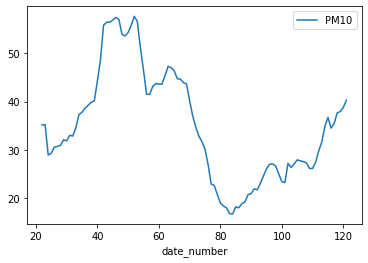

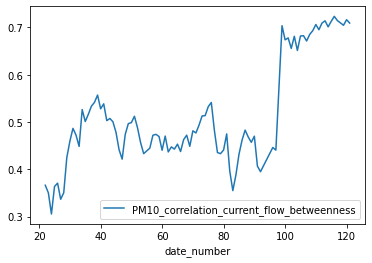

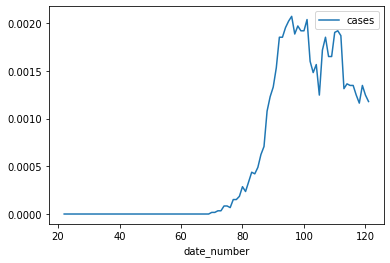

In [12]:
plt.close()
df[df['county']=='Ventura'].plot('date_number', 'PM10', kind='line')
df[df['county']=='Ventura'].plot('date_number', 'PM10_correlation_current_flow_betweenness', kind='line')
df[df['county']=='Ventura'].plot('date_number', 'cases', kind='line')
plt.show()

In [13]:
df = df[total_head]

In [14]:
df.tail(5)

,PM2,PM10,O3,cases,deaths,mean_pressure,mean_rh,mean_temp,mean_wind,PM2_correlation_current_flow_betweenness,PM10_correlation_current_flow_betweenness,O3_correlation_current_flow_betweenness
165,13.357143,35.428571,0.054000,0.001246,0.001887,980.666667,71.250000,72.708333,5.337500,0.399742,0.714642,0.345387
166,13.928571,37.642857,0.055143,0.001162,0.002004,981.416667,71.416667,70.125000,5.712500,0.397254,0.709680,0.309702
167,14.357143,37.928571,0.056643,0.001348,0.002004,981.708333,75.458333,71.450000,6.004167,0.341880,0.704718,0.302437
168,14.500000,38.785714,0.057357,0.001246,0.002004,981.875000,85.791667,68.684211,6.012500,0.385966,0.716461,0.294243
169,14.071429,40.285714,0.057000,0.001179,0.002122,979.833333,80.416667,68.125000,5.729167,0.387998,0.709372,0.338220


In [15]:
X = df.drop(['cases', 'deaths'], axis=1)
y = df[[target]]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32)

In [17]:
regressor = XGBRegressor()

params={
 "learning_rate"    : [0.001, 0.08,0.01, 0.025, 0.05, 0.10, 0.09,  0.15, 0.20, 0.25, 0.30, 0.5 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 7, 8],
 "min_child_weight" : [ 1, 2, 3, 4, 5, 6, 7, 8 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7 ],
 "colsample_bytree" : [ 0.1, 0.3, 0.4, 0.5 , 0.7, 0.8 ],
  "n_estimators": [100, 150, 200, 250, 300]
}

In [18]:
my_scorer = make_scorer(r2_score, greater_is_better=True)

In [19]:
"""
‘neg_mean_absolute_error’
explained_variance
neg_mean_squared_error
"""
random_search=RandomizedSearchCV(regressor,param_distributions=params,
                           n_iter=15,
                           scoring='neg_mean_squared_error',
                           n_jobs=6,
                           cv=30,
                           verbose=3)

In [20]:
import time
start = time.time()
random_search.fit(X_train,y_train)
end = time.time()
print(end-start)

Fitting 30 folds for each of 15 candidates, totalling 450 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 413 tasks      | elapsed:    2.4s
[Parallel(n_jobs=6)]: Done 450 out of 450 | elapsed:    2.5s finished


2.6812498569488525


In [21]:
random_search.best_params_

{'n_estimators': 300,
 'min_child_weight': 4,
 'max_depth': 8,
 'learning_rate': 0.025,
 'gamma': 0.0,
 'colsample_bytree': 0.5}

In [22]:
model = XGBRegressor(**random_search.best_params_)
model.fit(X_train, y_train) 

Y_pred=model.predict(X_test)
Y_pred_train=model.predict(X_train)

regression_report(y_train, Y_pred_train),regression_report(y_test, Y_pred)

float division by zero
float division by zero


({'Explained Variance': 0.8534168758081397,
  'Mean Squared Error': 1.787905691804031e-07,
  'Mean Absolute Error': 0.00036978282131459894,
  'Mean Squared Log Error': 1.7860330615261064e-07,
  'Median Absolute Error': 0.000427455050318748,
  'MAPE': None,
  'r2_score': 0.7212683210138306,
  'RMSE': 0.000422836338528754},
 {'Explained Variance': 0.8728437003278673,
  'Mean Squared Error': 2.238748764323528e-07,
  'Mean Absolute Error': 0.0004239071692002956,
  'Mean Squared Log Error': 2.236837159992326e-07,
  'Median Absolute Error': 0.0004284381866455078,
  'MAPE': None,
  'r2_score': 0.40269282443735577,
  'RMSE': 0.00047315417828901483})

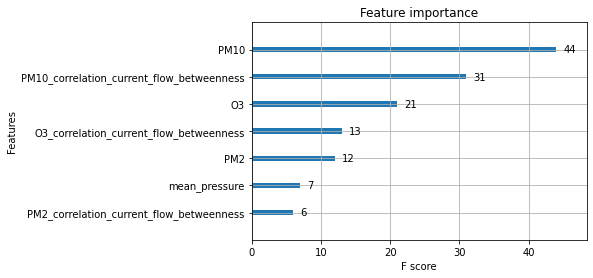

In [23]:
from xgboost import plot_importance

plot_importance(model)

float division by zero


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


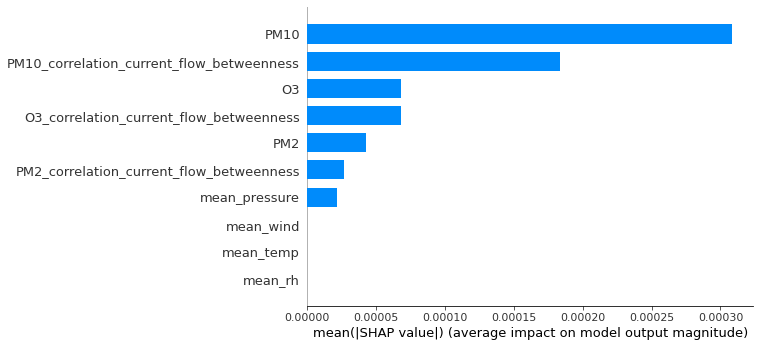

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


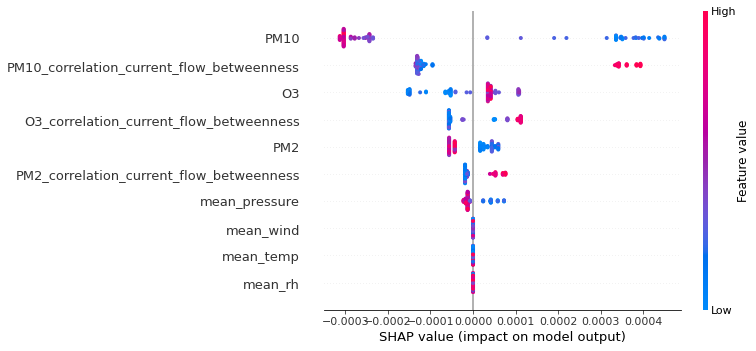

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


In [24]:
Y_pred_complete=model.predict(X)
regression_report(y, Y_pred_complete)

explained = shap.TreeExplainer(model)
shap_values = explained.shap_values(X)

f = plt.figure()
shap.summary_plot(shap_values, X, plot_type="bar")
f.savefig("images/summary_plot1_{}.png".format(metric[0]), bbox_inches='tight', dpi=600)
f.show()

f = plt.figure()
shap.summary_plot(shap_values, X)
f.savefig("images/summary_plot2_{}.png".format(metric[0]), bbox_inches='tight', dpi=600)
f.show()

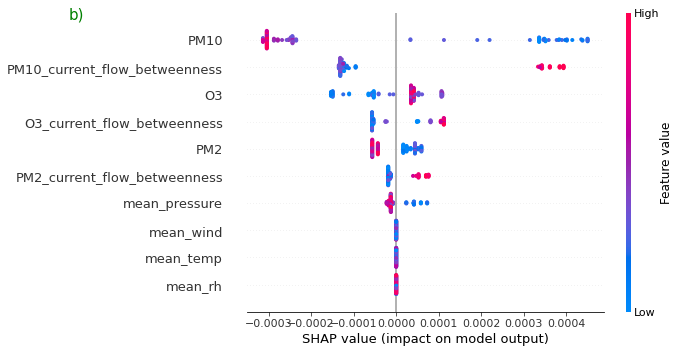

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


In [25]:
X.columns = [i.replace('correlation_', '') for i in X.columns]

explained = shap.TreeExplainer(model)
shap_values = explained.shap_values(X)

f = plt.figure()
ax = plt.gca()
ax.text(-0.5, 0.98, 'b)', transform=ax.transAxes, size=15, color='green')
shap.summary_plot(shap_values, X, max_display=10)
f.savefig("images/SA3b.png".format(metric[0]), bbox_inches='tight', dpi=600)
f.show()

In [26]:

model = XGBRegressor()
model.fit(X_train, y_train) 

Y_pred=model.predict(X_test)
Y_pred_train=model.predict(X_train)

regression_report(y_train, Y_pred_train),regression_report(y_test, Y_pred)
# Y_pred_train, model.score(X_train, Y_pred_train)

float division by zero
float division by zero


({'Explained Variance': 0.905919364739208,
  'Mean Squared Error': 6.03473936557589e-08,
  'Mean Absolute Error': 0.0001837517466917053,
  'Mean Squared Log Error': 6.021016035325851e-08,
  'Median Absolute Error': 0.00010839104652404785,
  'MAPE': None,
  'r2_score': 0.9059193645771297,
  'RMSE': 0.00024565706514521196},
 {'Explained Variance': 0.8640304249163894,
  'Mean Squared Error': 6.28351274166154e-08,
  'Mean Absolute Error': 0.00019491160613211673,
  'Mean Squared Log Error': 6.27642141928879e-08,
  'Median Absolute Error': 0.00010839104652404785,
  'MAPE': None,
  'r2_score': 0.8323533525447718,
  'RMSE': 0.00025066935875095583})

In [27]:
model.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)>